# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
%config Completer.use_jedi = False

In [2]:
# install dependencies: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.1 True
gcc (GCC) 11.1.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [4]:
import matplotlib.pyplot as plt

In [5]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

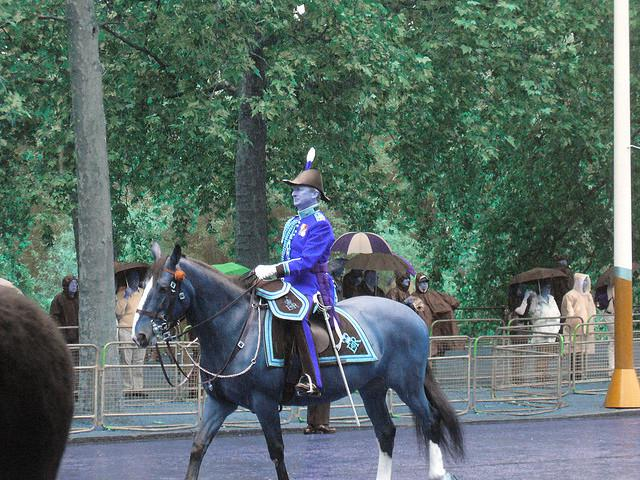

In [6]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
showarray(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [7]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/step/miniconda3/envs/ml-torch/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [8]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6019, 244.8971, 459.8288, 480.0000],
        [251.1102, 157.8143, 338.9720, 413.6351],
        [114.8494, 268.6843, 148.2350, 398.8112],
        [  0.8216, 281.0323,  78.6074, 478.4206],
        [ 49.3957, 274.1225,  80.1544, 342.9811],
        [561.2253, 271.5821, 596.2756, 385.2554],
        [385.9071, 270.3125, 413.7130, 304.0399],
        [515.9294, 278.3739, 562.2789, 389.3831],
        [335.2375, 251.9165, 414.7497, 275.9379],
        [350.9305, 269.2060, 386.0980, 297.9094],
        [331.6285, 230.9997, 393.2755, 257.2008],
        [510.7352, 263.2656, 570.9866, 295.9196],
        [409.0863, 271.8639, 460.5584, 356.8695],
        [506.8770, 283.3262, 529.9407, 324.0393],
        [594.5665, 283.4821, 609.0580, 311.4132]], device='cuda:0'))


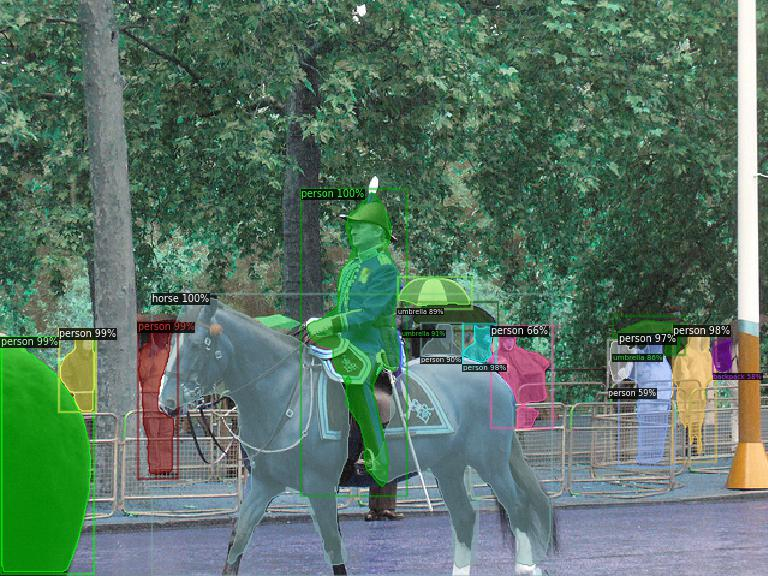

In [9]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
showarray(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [10]:
# download, decompress the data
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [11]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



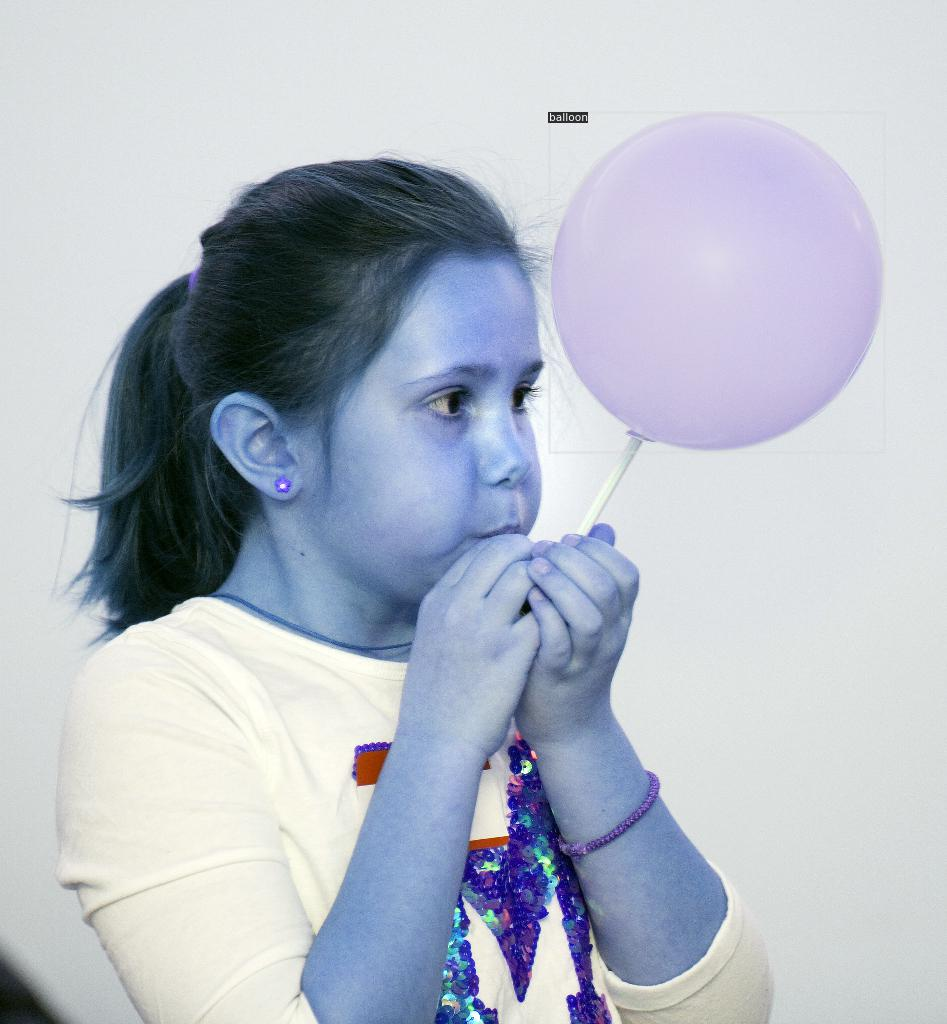

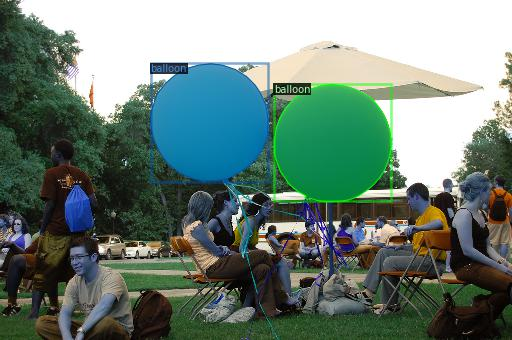

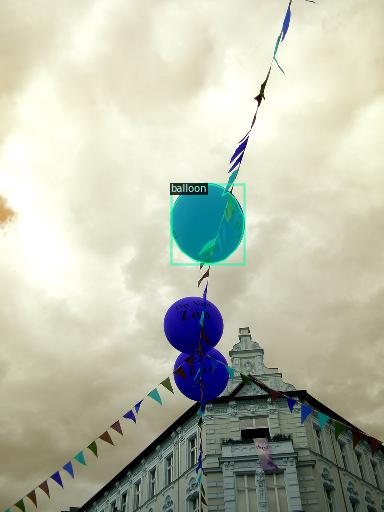

In [13]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    showarray(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/05 04:08:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/05 04:08:58 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[06/05 04:08:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/05 04:08:58 d2.data.build]: Using training sampler TrainingSampler
[06/05 04:08:58 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[06/05 04:08:58 d2.data.common]: Serialized dataset takes 0.17 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/05 04:08:58 d2.engine.train_loop]: Starting training from iteration 0
[06/05 04:09:03 d2.utils.events]:  eta: 0:01:08  iter: 19  total_loss: 2.037  loss_cls: 0.6851  loss_box_reg: 0.6638  loss_mask: 0.6838  loss_rpn_cls: 0.03503  loss_rpn_loc: 0.007335  time: 0.2424  data_time: 0.0105  lr: 4.9953e-06  max_mem: 4530M
[06/05 04:09:08 d2.utils.events]:  eta: 0:01:01  iter: 39  total_loss: 1.953  loss_cls: 0.6407  loss_box_reg: 0.6371  loss_mask: 0.6555  loss_rpn_cls: 0.0363  loss_rpn_loc: 0.00898  time: 0.2372  data_time: 0.0024  lr: 9.9902e-06  max_mem: 4530M
[06/05 04:09:13 d2.utils.events]:  eta: 0:00:57  iter: 59  total_loss: 1.849  loss_cls: 0.5637  loss_box_reg: 0.6478  loss_mask: 0.6074  loss_rpn_cls: 0.05396  loss_rpn_loc: 0.00896  time: 0.2414  data_time: 0.0026  lr: 1.4985e-05  max_mem: 4530M
[06/05 04:09:18 d2.utils.events]:  eta: 0:00:51  iter: 79  total_loss: 1.696  loss_cls: 0.496  loss_box_reg: 0.5906  loss_mask: 0.533  loss_rpn_cls: 0.03192  loss_rpn_loc: 0.006496  tim

In [16]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [17]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

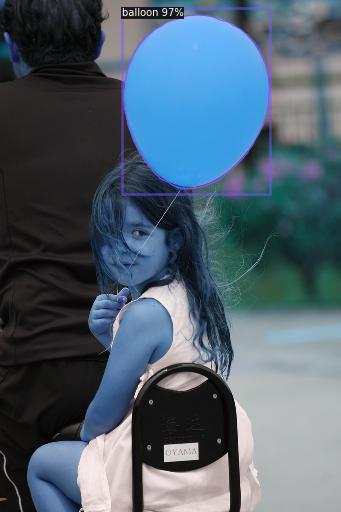

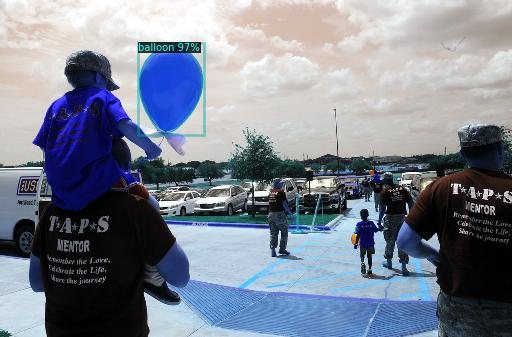

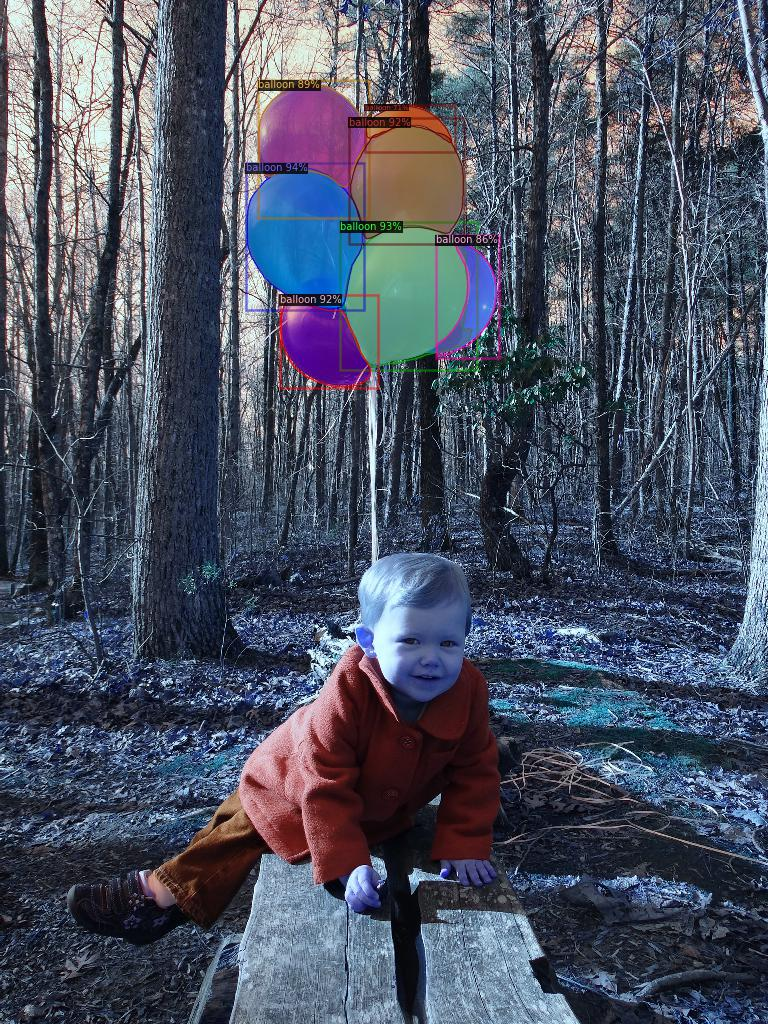

In [18]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    showarray(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/05 04:10:12 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[06/05 04:10:12 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[06/05 04:10:13 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/05 04:10:13 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[06/05 04:10:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[06/05 04:10:13 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[06/05 04:10:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/05 04:10:13 d2.data.common]: Serializing 13 elements to

# Other types of builtin models

We showcase simple demos of other types of models below:

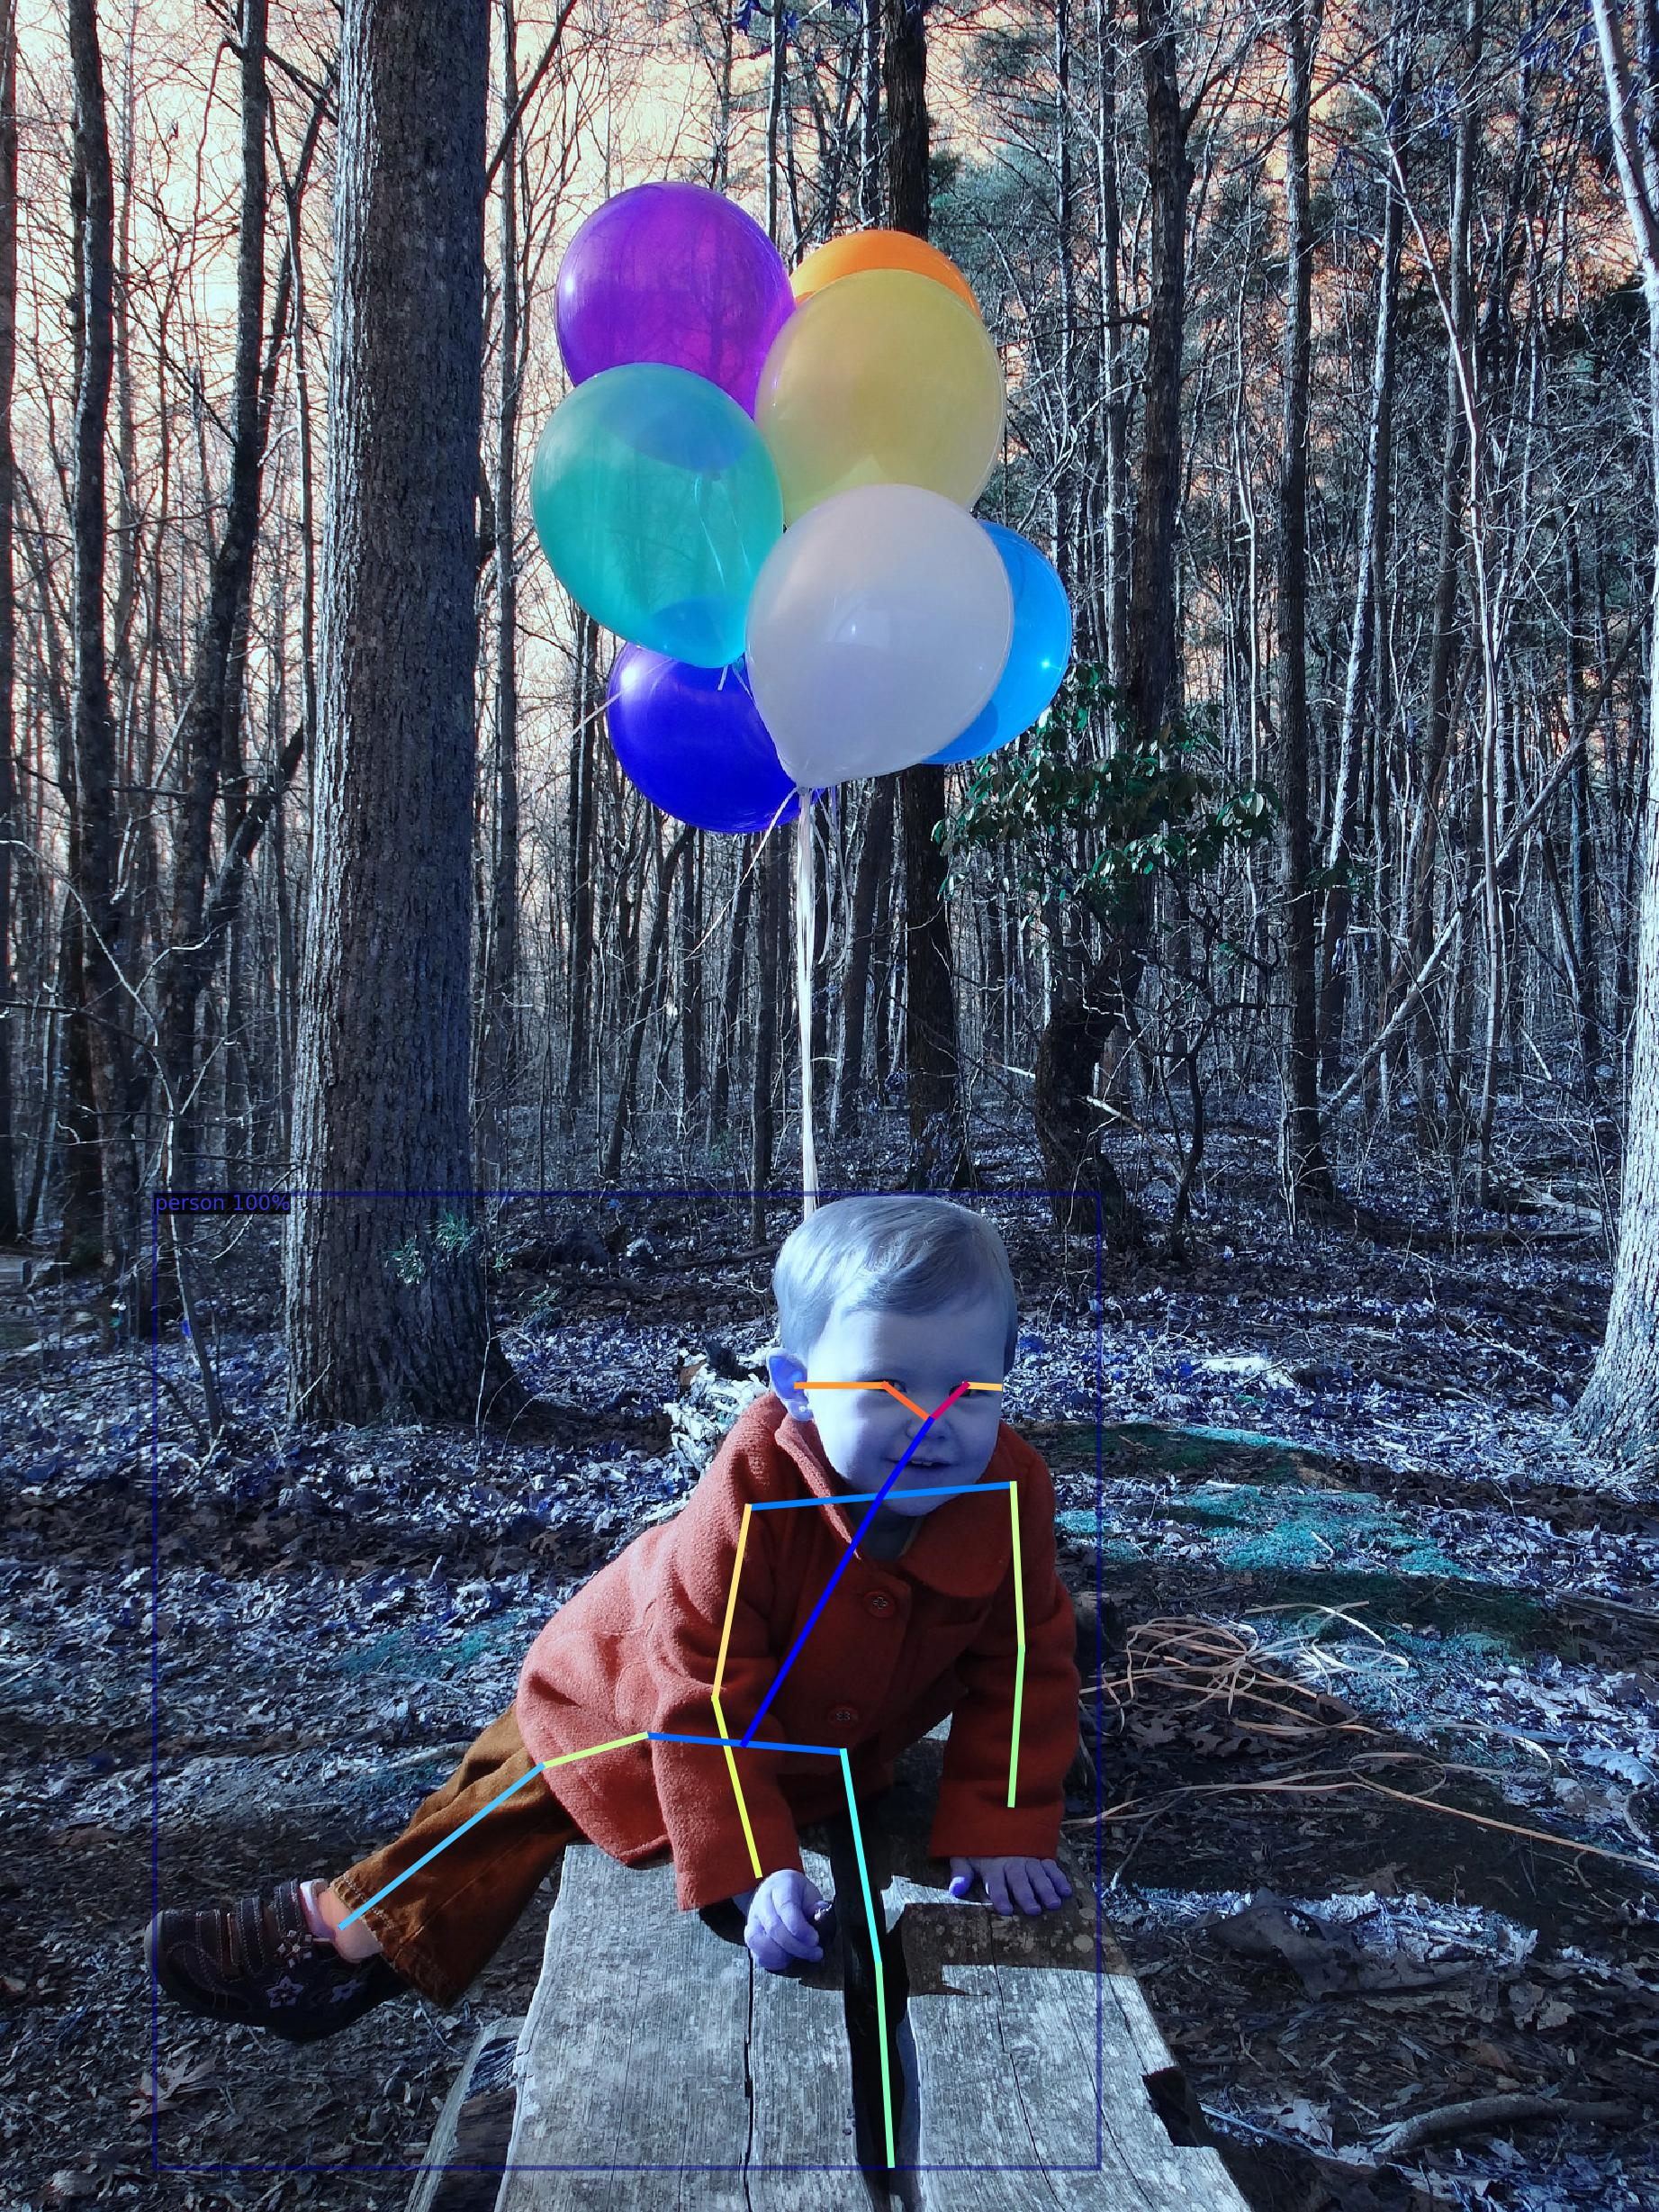

In [22]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
showarray(out.get_image()[:, :, ::-1])

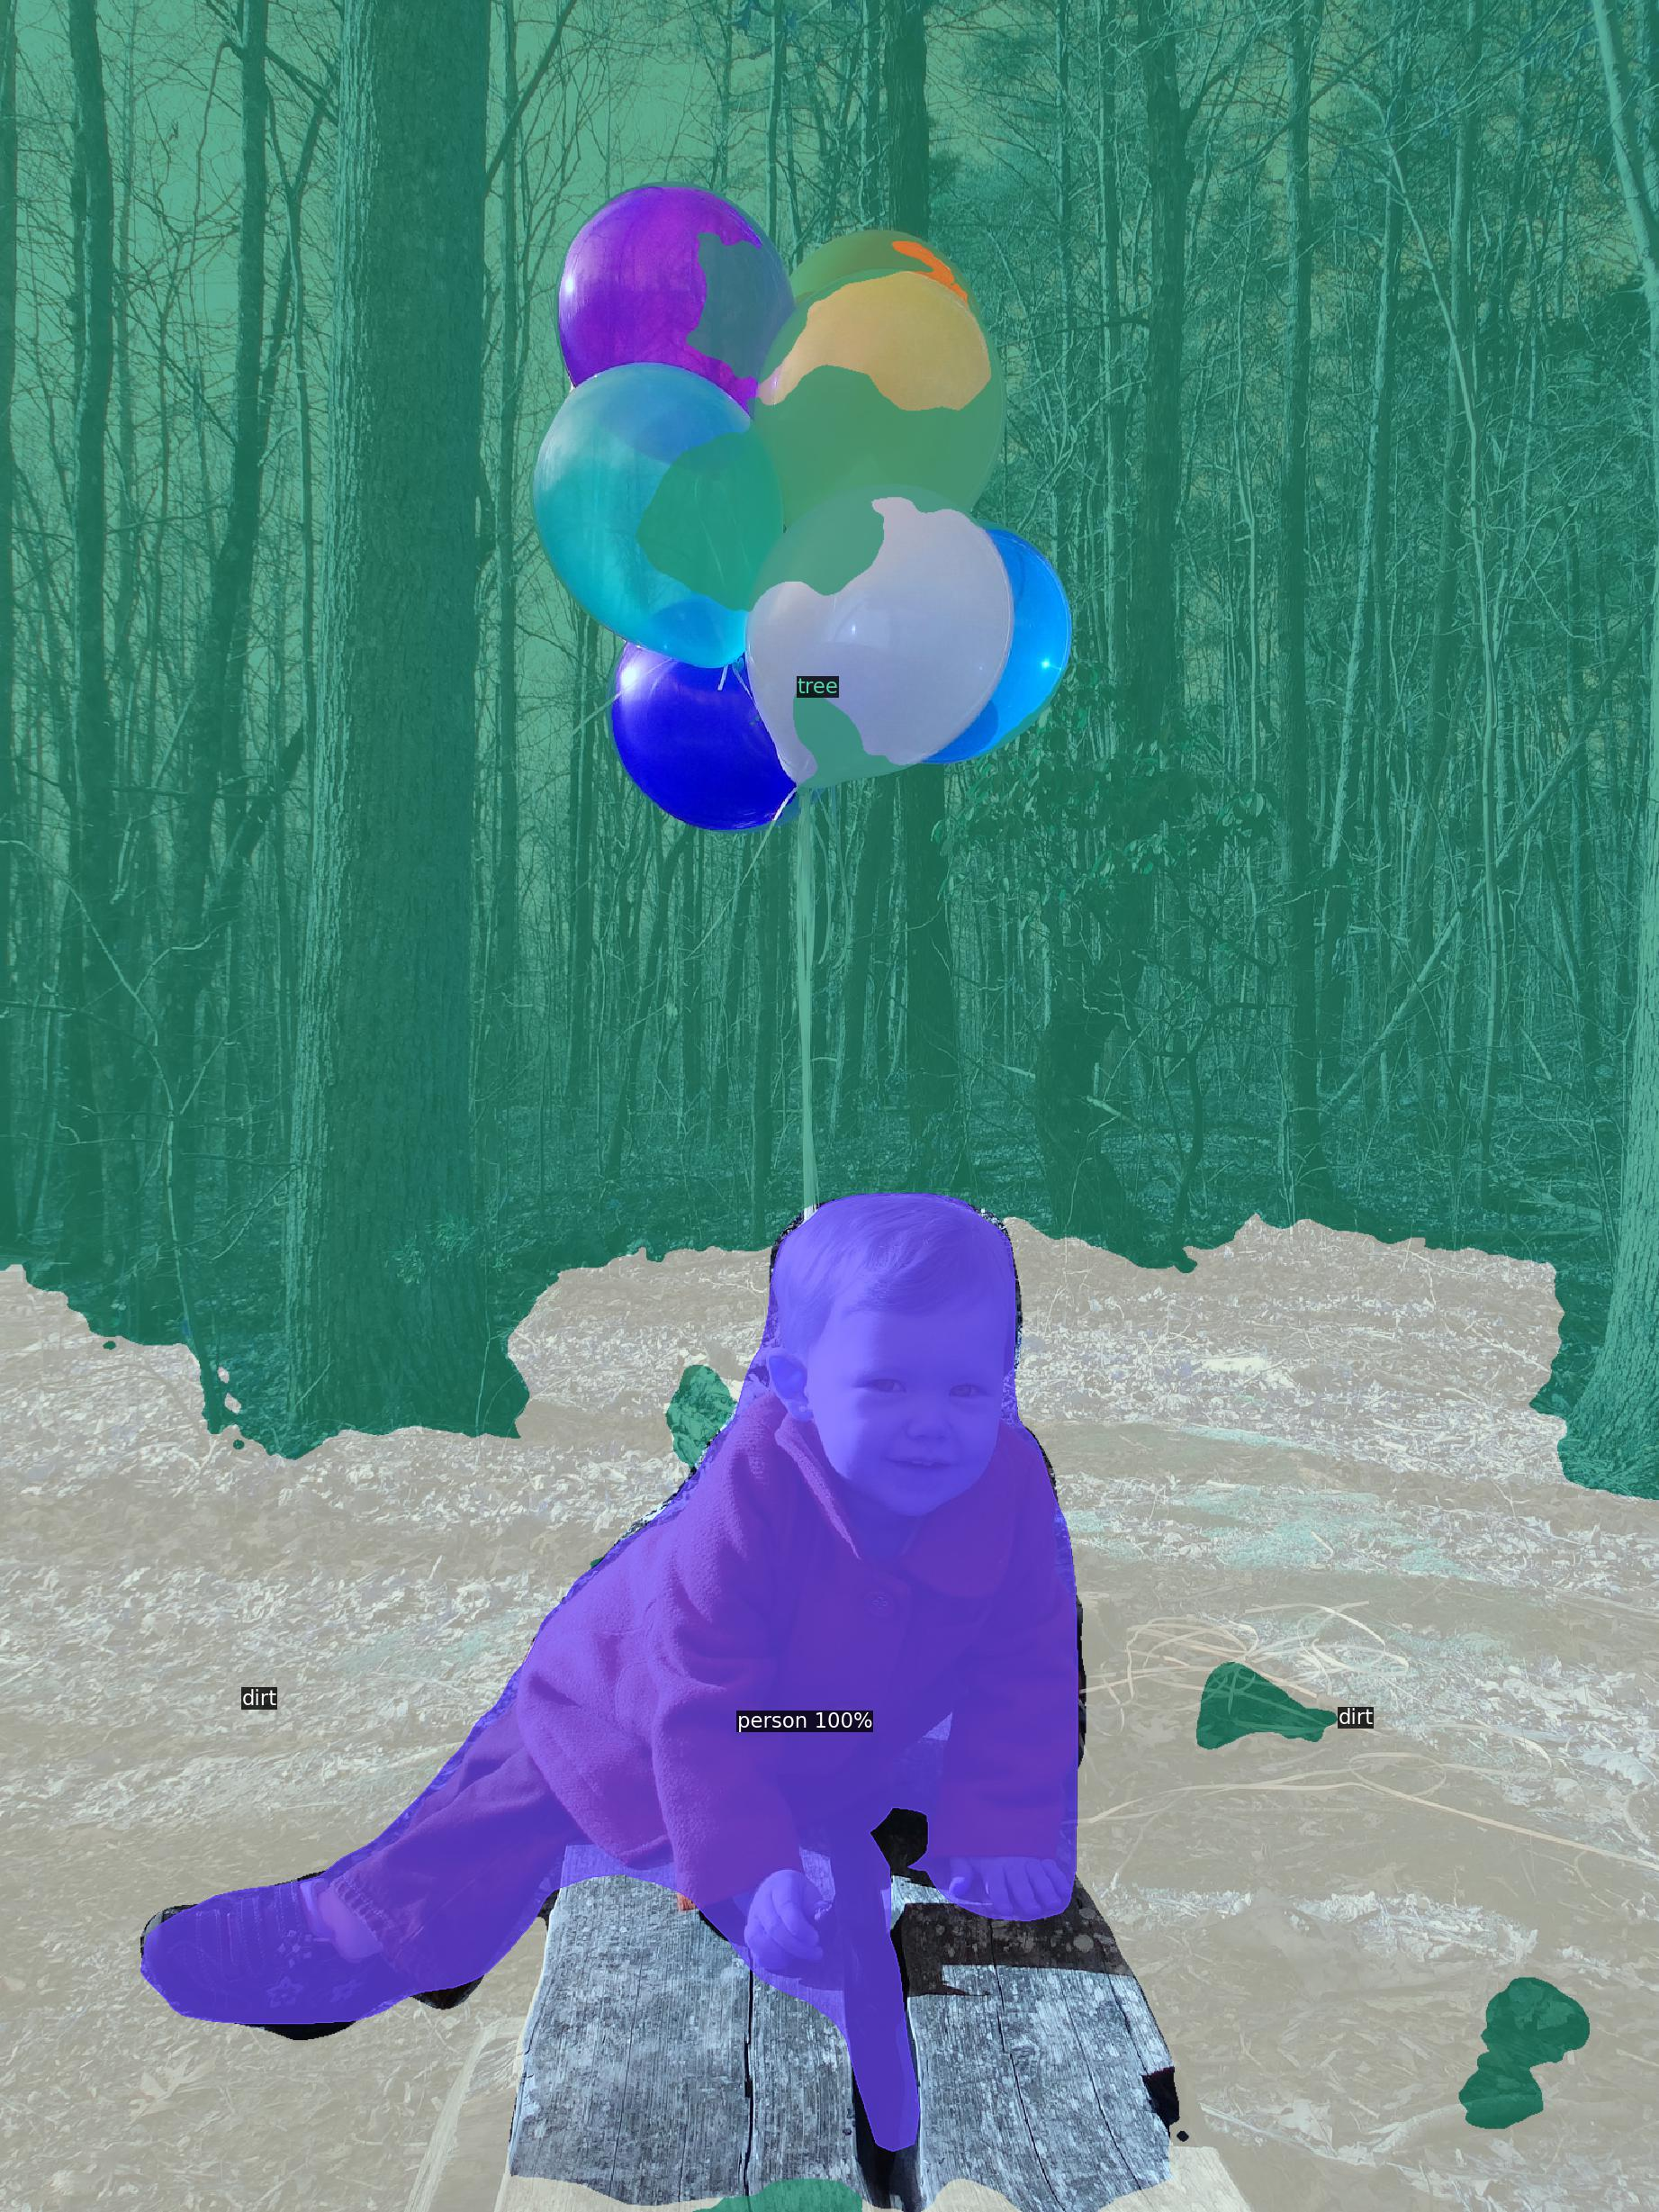

In [24]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
showarray(out.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')